# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import plotly.graph_objs as go
import plotly.graph_objs as go
import plotly.offline as pyoff

from tools import *


pyoff.init_notebook_mode(connected=True)

In [2]:
# TRAINING PARAMETERS

size=128 #Image size
BS = 64
NB_EPOCHS = 10
MAX_LR = 2e-3

HIST = True

# DATA PREPARATION
path = untar_data(URLs.IMAGENETTE_160)
tfms = get_transforms(do_flip=False)
data = ImageList.from_folder(path).split_by_folder(valid='val').label_from_folder().transform(tfms, size=size).databunch(bs=BS).presize(size, scale=(0.35,1)).normalize(imagenet_stats)

# OTHERS
append_stats = partial(append_stats_n, HIST)
recorder = RecordExp()
activations_prestats=[]

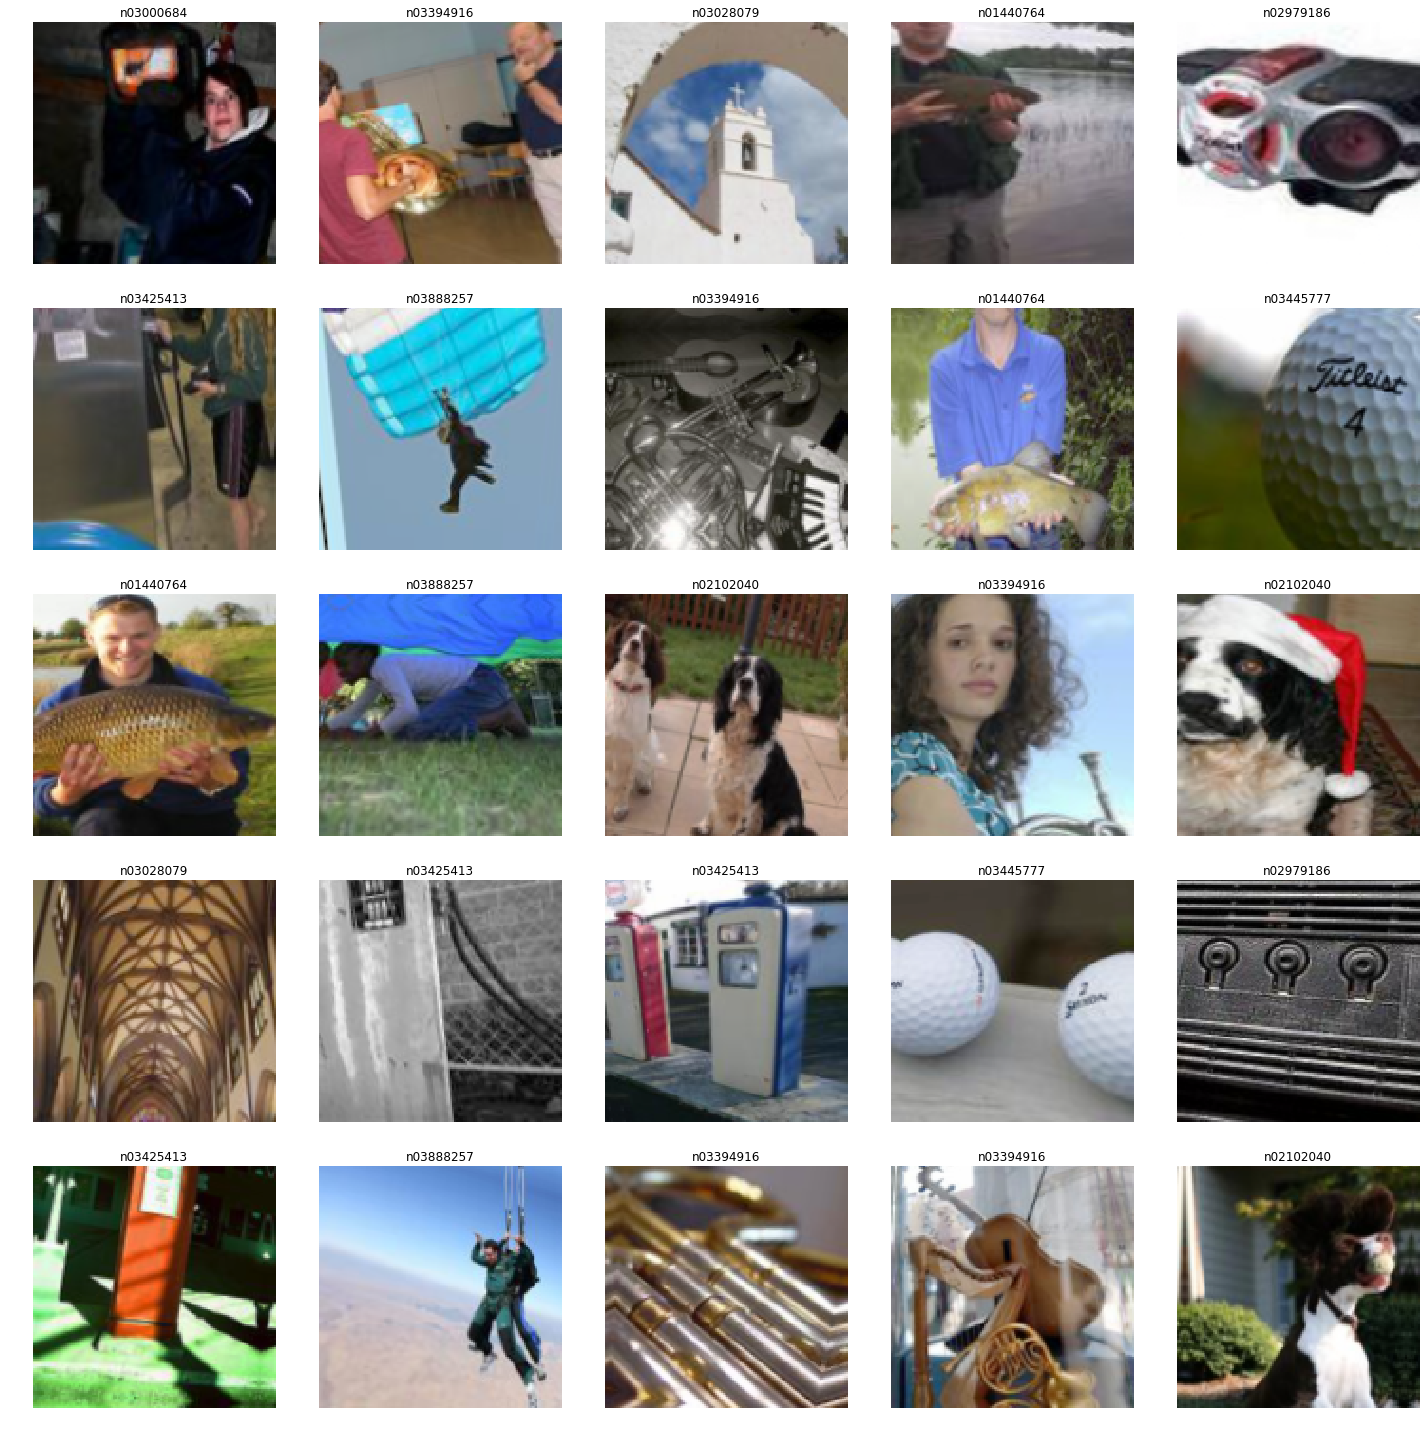

In [3]:
data.show_batch()

Model building

In [7]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=0, sub=0, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak != 0 else F.relu(x)
        if self.sub != 0: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(**kwargs)
    
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self):
        return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight
    

def noop(x): return x

def is_monitored_layer(l):
    mon_layers = (nn.Linear, ConvLayer)
    return isinstance(l, mon_layers)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
        


In [8]:
def get_first_model():
    model = nn.Sequential(ConvLayer(3, 32, ks=5), ConvLayer(32, 64), ConvLayer(64, 128), ConvLayer(128, 128), 
                      nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(128, data.c))
    learn = Learner(data, model, metrics=[accuracy])
    
    return model, learn

# Pytorch default init

In [9]:
model, learn = get_first_model()


In [10]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 64]         2,432      True      
______________________________________________________________________
GeneralRelu          [32, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         18,496     True      
______________________________________________________________________
GeneralRelu          [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [128, 16, 16]        73,856     True      
______________________________________________________________________
GeneralRelu          [128, 16, 16]        0          False     
______________________________________________________________________
Conv2d               [128, 8, 8]          147,584    True      
______________________________________________________________

In [11]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)
assert(len(activations_prestats) == 1)

ConvLayer: 
[tensor(0.2510)] / [tensor(0.3927)]

ConvLayer: 
[tensor(0.0880)] / [tensor(0.1450)]

ConvLayer: 
[tensor(0.0365)] / [tensor(0.0553)]

ConvLayer: 
[tensor(0.0132)] / [tensor(0.0218)]

Linear(in: 
[tensor(-0.0057)] / [tensor(0.0537)]



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


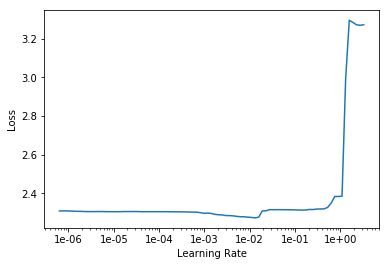

In [12]:
model, learn = get_first_model()

learn.lr_find()
learn.recorder.plot()

In [13]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

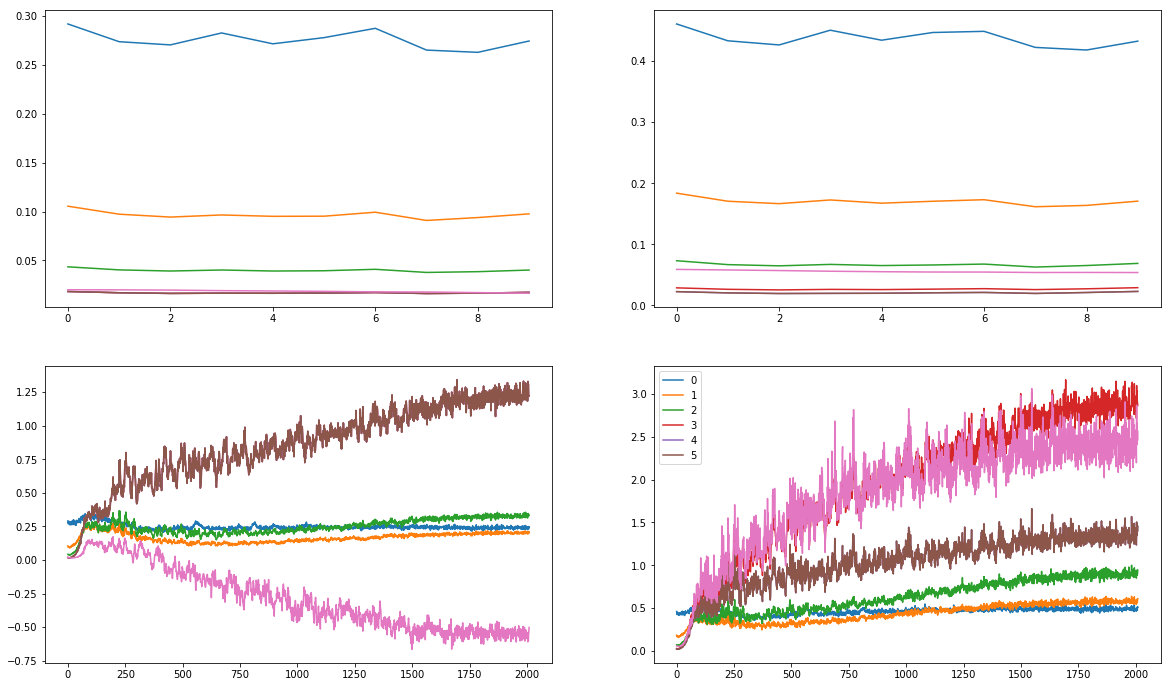

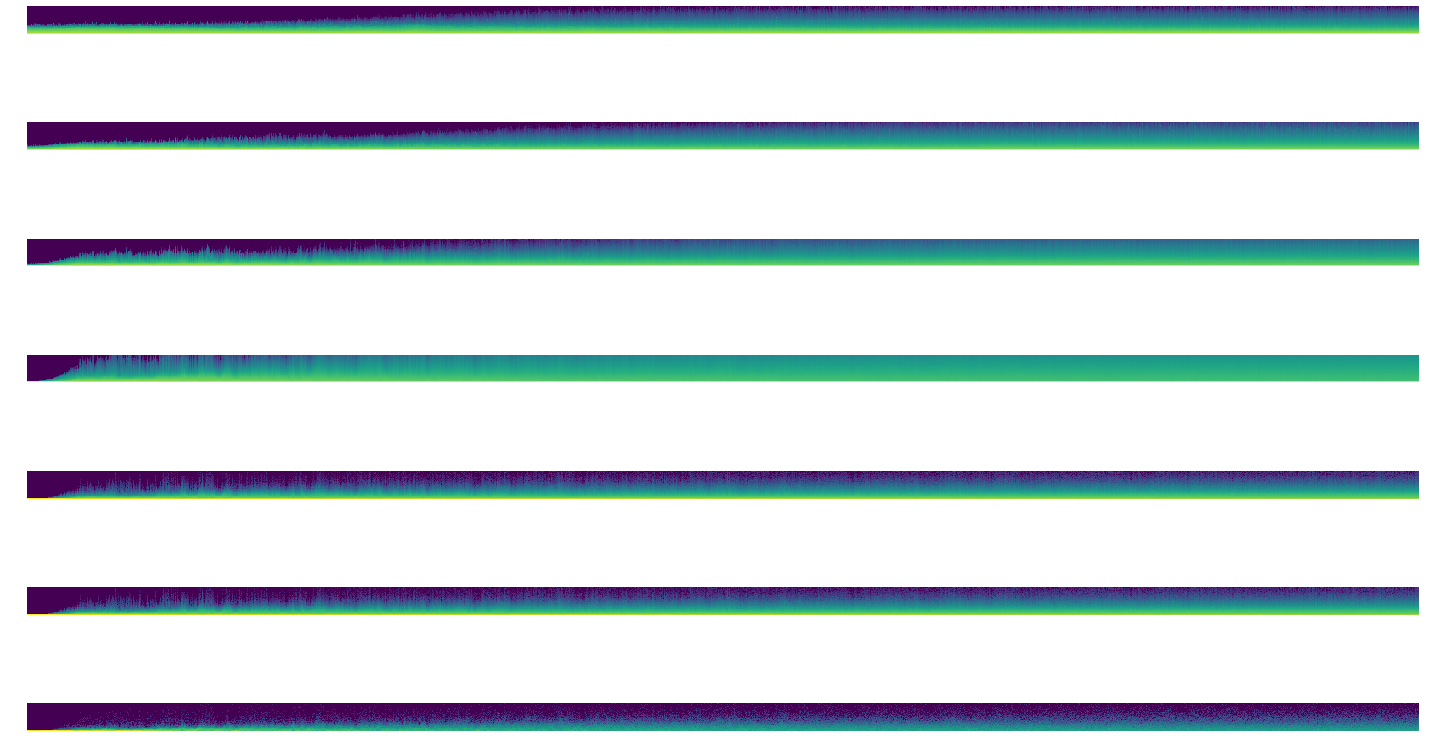

In [14]:
recorder.add_exp(learn.recorder, "pytorch default")
viz(hooks)

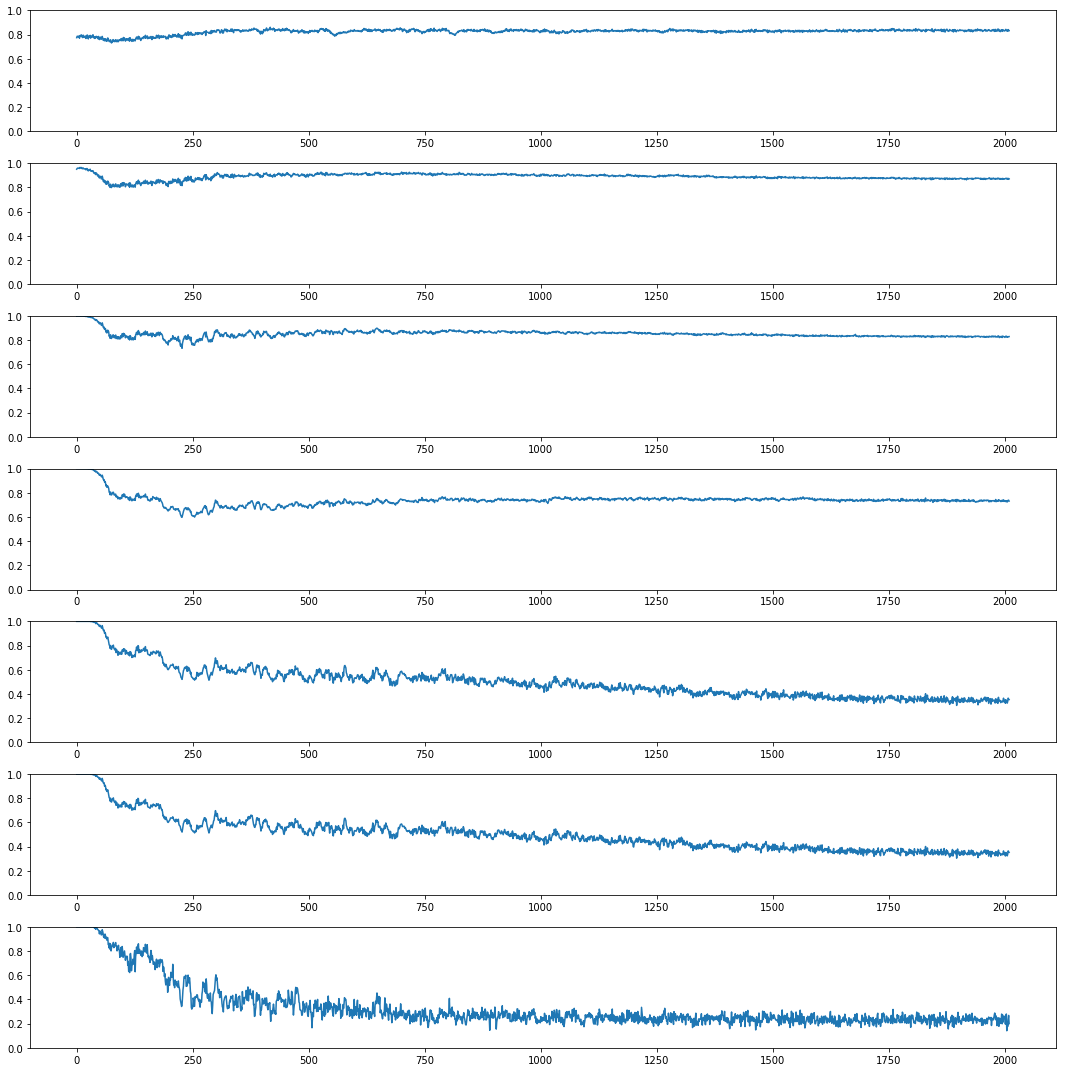

In [15]:
if HIST:
    stats_ratio_zeros(hooks)

# Kaiming init

In [16]:
model, learn = get_first_model()
get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.3147)] / [tensor(0.4892)]

ConvLayer: 
[tensor(0.1433)] / [tensor(0.2192)]

ConvLayer: 
[tensor(0.0605)] / [tensor(0.0930)]

ConvLayer: 
[tensor(0.0252)] / [tensor(0.0389)]

Linear(in: 
[tensor(0.0099)] / [tensor(0.0640)]



[([tensor(0.3147)], [tensor(0.4892)]),
 ([tensor(0.1433)], [tensor(0.2192)]),
 ([tensor(0.0605)], [tensor(0.0930)]),
 ([tensor(0.0252)], [tensor(0.0389)]),
 ([tensor(0.0099)], [tensor(0.0640)])]

In [17]:
def init_cnn(m, uniform=False):
    f = nn.init.kaiming_uniform_ if uniform else nn.init.kaiming_normal_
    for l in m:
        if isinstance(l, ConvLayer):
            print('Init Conv layer')
            f(l.conv.weight, a=0)
            l.conv.bias.data.zero_()
        if isinstance(l, nn.Linear):
            print('Init Linear layer')
            nn.init.xavier_normal_(l.weight)
            l.bias.data.zero_()


In [18]:
init_cnn(model)

Init Conv layer
Init Conv layer
Init Conv layer
Init Conv layer
Init Linear layer


In [19]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

ConvLayer: 
[tensor(0.8434)] / [tensor(1.3039)]

ConvLayer: 
[tensor(0.7695)] / [tensor(1.2524)]

ConvLayer: 
[tensor(0.8076)] / [tensor(1.2951)]

ConvLayer: 
[tensor(0.6565)] / [tensor(1.1449)]

Linear(in: 
[tensor(0.4239)] / [tensor(1.4362)]



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


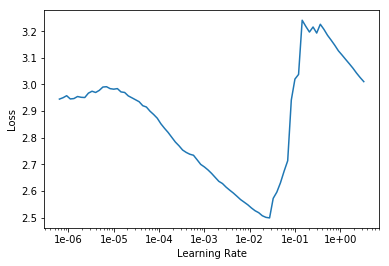

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

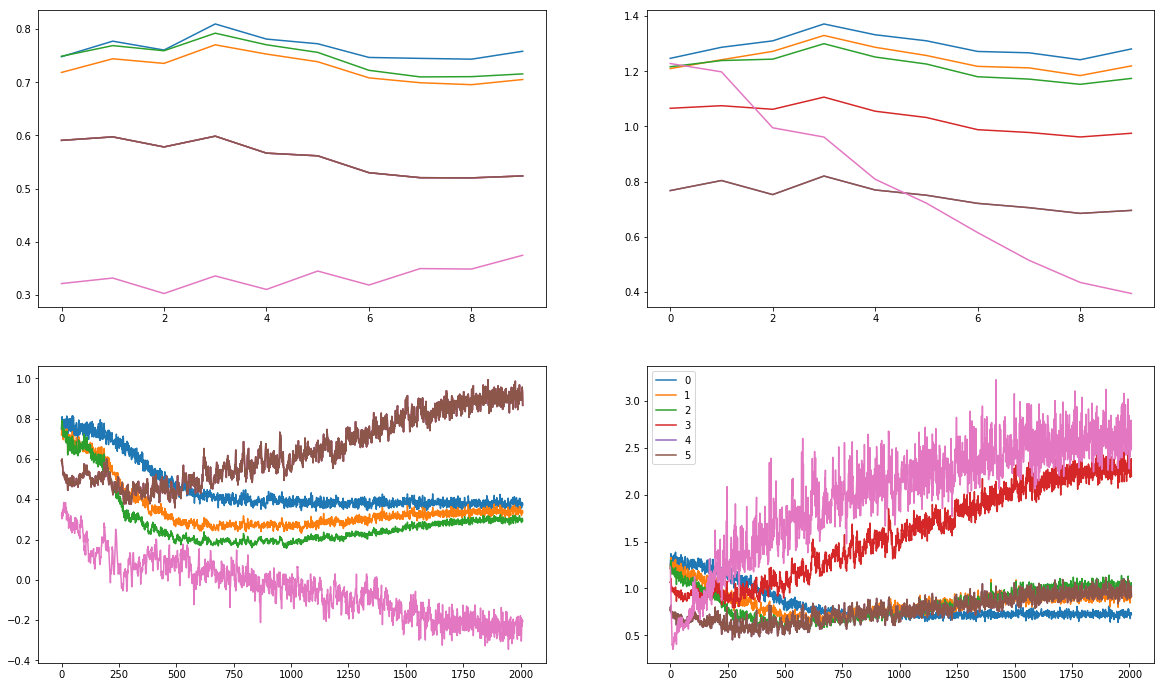

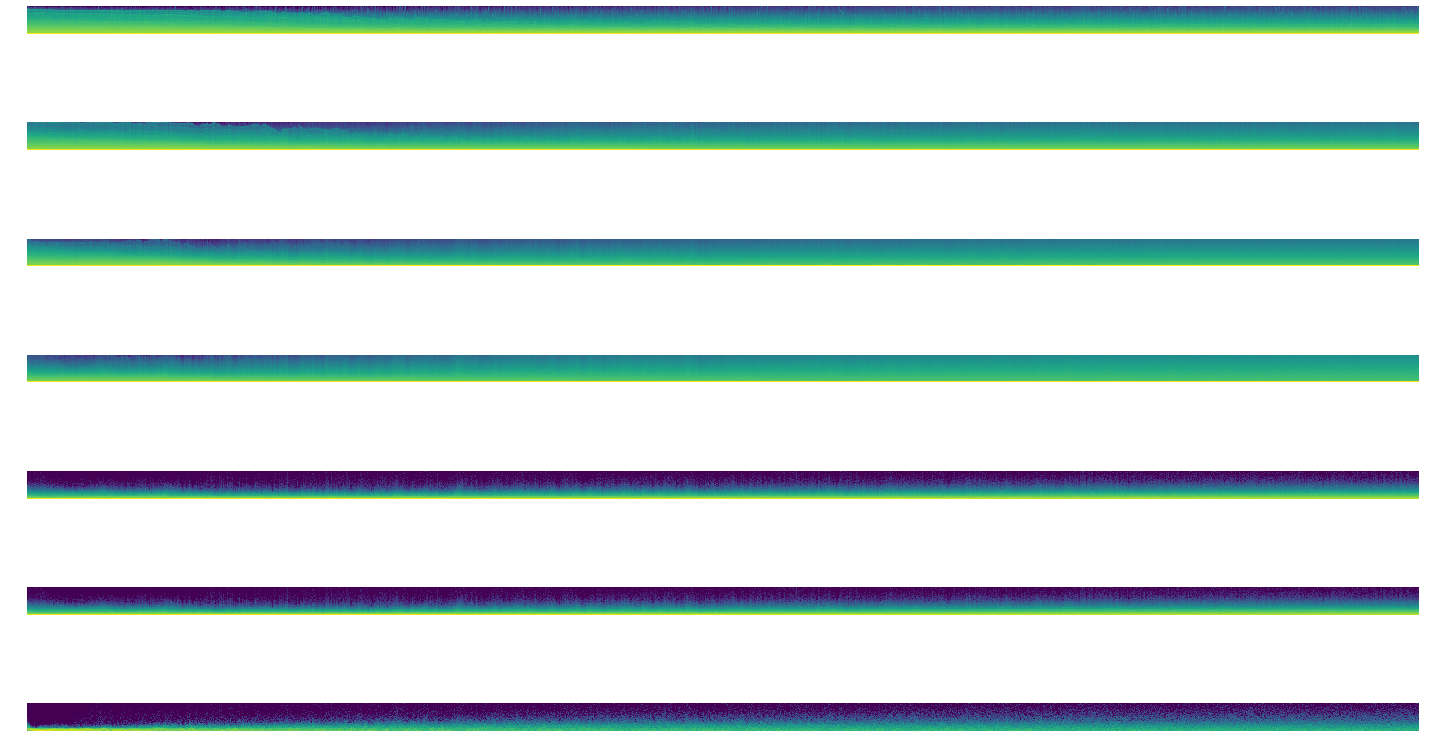

In [22]:
recorder.add_exp(learn.recorder, 'Kaiming init')
viz(hooks)

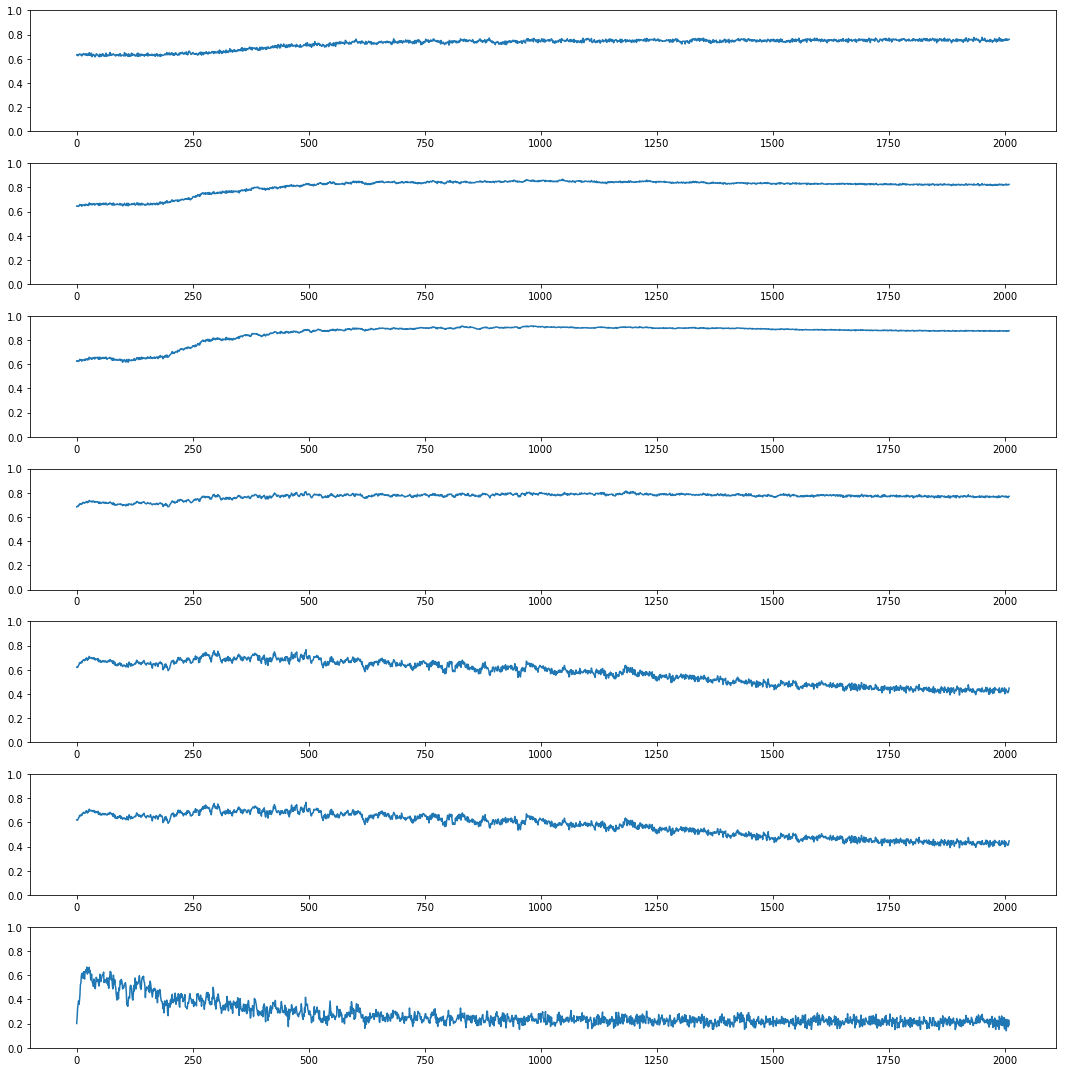

In [23]:
if HIST:
    stats_ratio_zeros(hooks)

# LSUV init

In [24]:

def lsuv_conv(m, xb, model, debug=False):
    h = Hook2(m, init_stats)
      

    
    while model(xb) is not None and abs(h.stats[0][-1])  > 1e-3: 
        if debug: print(f'Len stats: {len(h.stats[0])}')
        if debug: print(f'Working on the bias of module {str(h.mod)[:9]}, val before= {m.bias}')
        m.bias -= h.stats[0][-1]
        if debug: print(f'after = {m.bias}\n')
       
     
    while model(xb) is not None and abs(h.stats[1][-1]-1) > 1e-3: 
        if debug: print(f'Len stats: {len(h.stats[0])}')
        if debug: print(f'Working on the std of module {str(h.mod)[:9]}, val before= {h.stats[1][-1]}')
        m.weight.data /= h.stats[1][-1]
        if debug: print(f'after = {m.weight.data.std()}\n')
    h.remove()    
    return h.stats[0][-1], h.stats[1][-1]

In [25]:
model, learn = get_first_model()
#layers_monitored = find_modules(model, is_monitored_layer)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.2531)] / [tensor(0.4107)]

ConvLayer: 
[tensor(0.1028)] / [tensor(0.1701)]

ConvLayer: 
[tensor(0.0445)] / [tensor(0.0711)]

ConvLayer: 
[tensor(0.0211)] / [tensor(0.0311)]

Linear(in: 
[tensor(-0.0101)] / [tensor(0.0625)]



[([tensor(0.2531)], [tensor(0.4107)]),
 ([tensor(0.1028)], [tensor(0.1701)]),
 ([tensor(0.0445)], [tensor(0.0711)]),
 ([tensor(0.0211)], [tensor(0.0311)]),
 ([tensor(-0.0101)], [tensor(0.0625)])]

In [26]:
def is_monitored_layer(l):
    mon_layers = (nn.Linear, ConvLayer)
    return isinstance(l, mon_layers)

In [27]:
xb = next(iter(data.train_dl))

In [28]:
model, learn = get_first_model()
layers_monitored = find_modules(model, is_monitored_layer)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.2594)] / [tensor(0.4571)]

ConvLayer: 
[tensor(0.1232)] / [tensor(0.1936)]

ConvLayer: 
[tensor(0.0571)] / [tensor(0.0882)]

ConvLayer: 
[tensor(0.0212)] / [tensor(0.0349)]

Linear(in: 
[tensor(0.0103)] / [tensor(0.0432)]



[([tensor(0.2594)], [tensor(0.4571)]),
 ([tensor(0.1232)], [tensor(0.1936)]),
 ([tensor(0.0571)], [tensor(0.0882)]),
 ([tensor(0.0212)], [tensor(0.0349)]),
 ([tensor(0.0103)], [tensor(0.0432)])]

In [29]:
init_cnn(model)

get_prestat(learn, is_monitored_layer)

Init Conv layer
Init Conv layer
Init Conv layer
Init Conv layer
Init Linear layer
ConvLayer: 
[tensor(0.7128)] / [tensor(1.1947)]

ConvLayer: 
[tensor(0.7415)] / [tensor(1.1686)]

ConvLayer: 
[tensor(0.6821)] / [tensor(1.1894)]

ConvLayer: 
[tensor(0.8621)] / [tensor(1.3509)]

Linear(in: 
[tensor(-0.4000)] / [tensor(1.6925)]



[([tensor(0.7128)], [tensor(1.1947)]),
 ([tensor(0.7415)], [tensor(1.1686)]),
 ([tensor(0.6821)], [tensor(1.1894)]),
 ([tensor(0.8621)], [tensor(1.3509)]),
 ([tensor(-0.4000)], [tensor(1.6925)])]

In [30]:
def is_conv_layer(l):
    mon_layers = (ConvLayer)
    return isinstance(l, ConvLayer)

In [31]:
for i, m in enumerate(find_modules(model, is_conv_layer)): 
    print(f'\n\nLayer {i}')
    print(lsuv_conv(m, xb[0], model))



Layer 0
(tensor(-0.1115), tensor(1.))


Layer 1
(tensor(0.0676), tensor(1.))


Layer 2
(tensor(0.0660), tensor(1.0000))


Layer 3
(tensor(0.0524), tensor(1.0000))


In [32]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

ConvLayer: 
[tensor(-0.0885)] / [tensor(1.0003)]

ConvLayer: 
[tensor(0.0672)] / [tensor(0.9534)]

ConvLayer: 
[tensor(0.0707)] / [tensor(0.9493)]

ConvLayer: 
[tensor(0.0662)] / [tensor(0.9332)]

Linear(in: 
[tensor(-0.1721)] / [tensor(0.8218)]



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


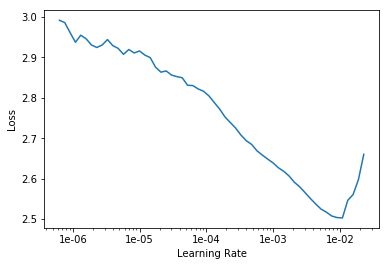

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

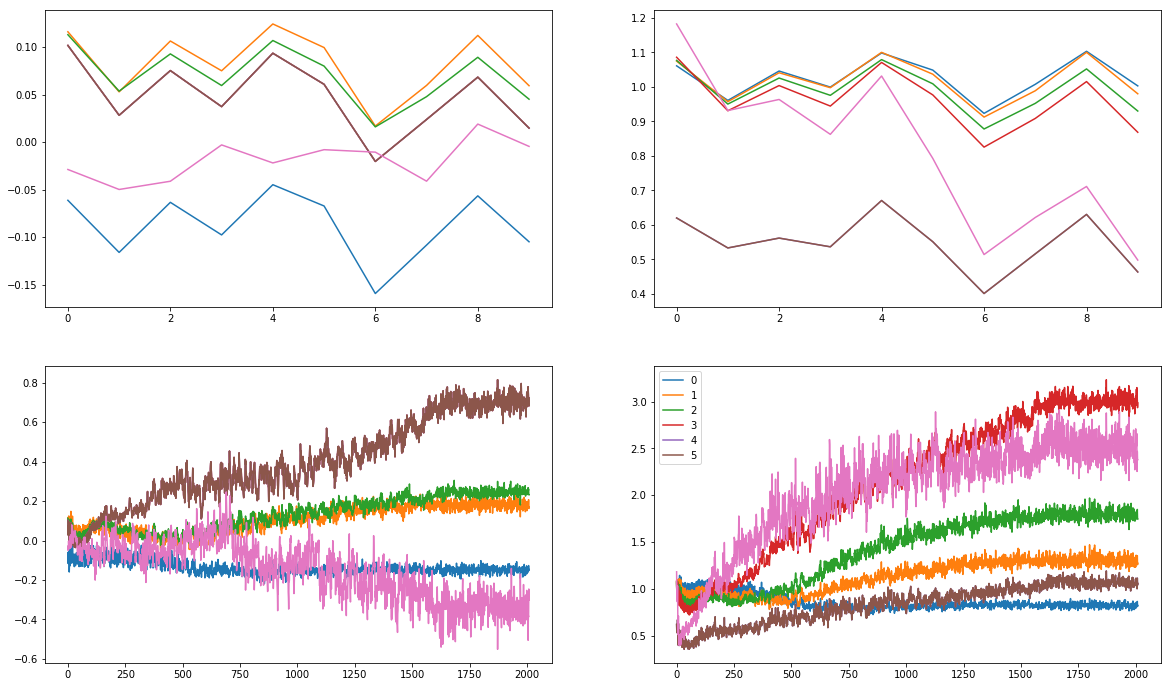

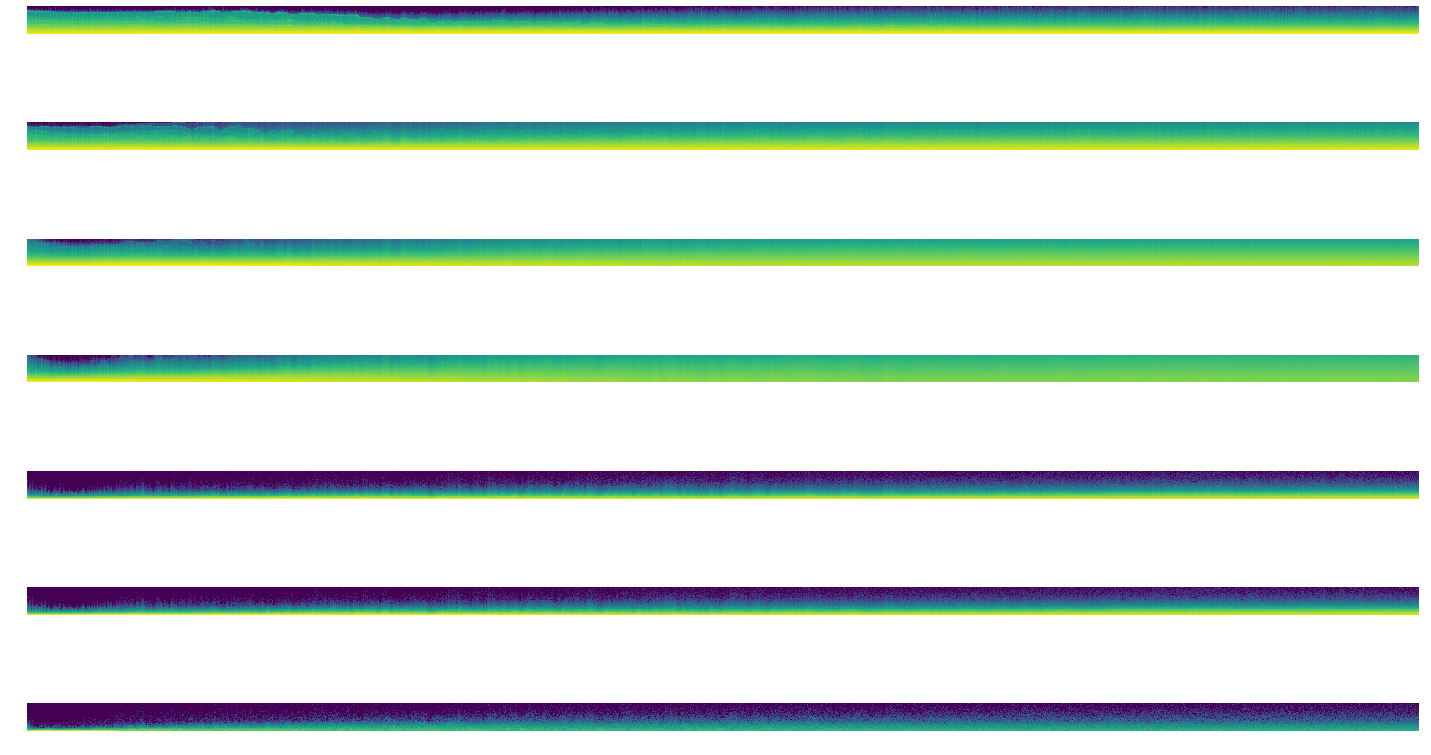

In [35]:
recorder.add_exp(learn.recorder, "LSUV init")
viz(hooks)

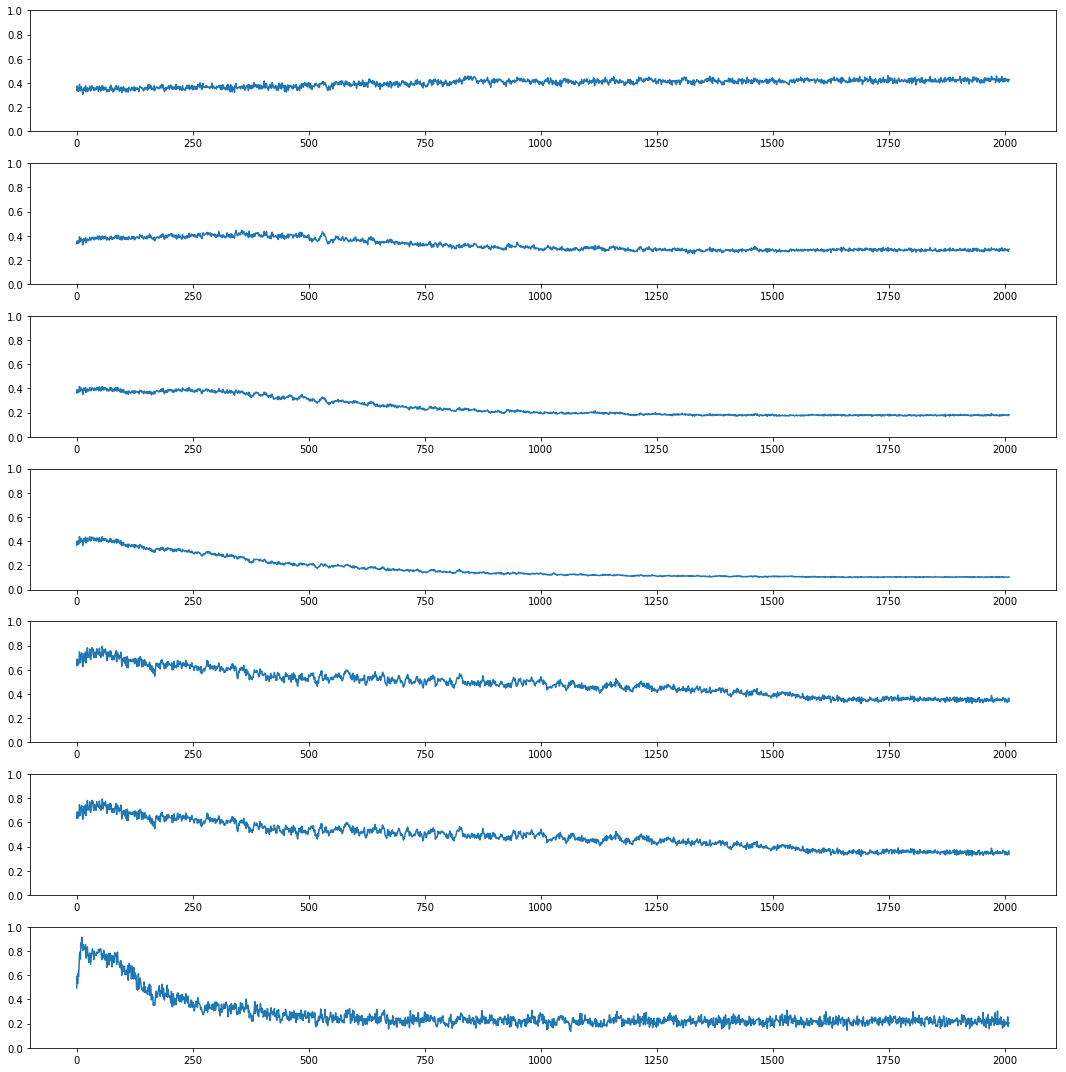

In [36]:
if HIST:
    stats_ratio_zeros(hooks)

# Random init

In [37]:
model, learn = get_first_model()
#layers_monitored = find_modules(model, is_monitored_layer)


get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.2630)] / [tensor(0.4145)]

ConvLayer: 
[tensor(0.0959)] / [tensor(0.1573)]

ConvLayer: 
[tensor(0.0353)] / [tensor(0.0595)]

ConvLayer: 
[tensor(0.0161)] / [tensor(0.0251)]

Linear(in: 
[tensor(-0.0148)] / [tensor(0.0550)]



[([tensor(0.2630)], [tensor(0.4145)]),
 ([tensor(0.0959)], [tensor(0.1573)]),
 ([tensor(0.0353)], [tensor(0.0595)]),
 ([tensor(0.0161)], [tensor(0.0251)]),
 ([tensor(-0.0148)], [tensor(0.0550)])]

In [38]:
def init_cnn_random(m, uniform=False):
    f = nn.init.normal_
    for l in m:
        if isinstance(l, ConvLayer):
            print('Init Conv layer')
            f(l.conv.weight)
            l.conv.bias.data.zero_()
        if isinstance(l, nn.Linear):
            print('Init Linear layer')
            f(l.weight)
            l.bias.data.zero_()


In [39]:
init_cnn_random(model)

Init Conv layer
Init Conv layer
Init Conv layer
Init Conv layer
Init Linear layer


In [40]:
get_prestat(learn, is_monitored_layer)
#activations_prestats.append(out)

ConvLayer: 
[tensor(4.0735)] / [tensor(6.4341)]

ConvLayer: 
[tensor(47.4039)] / [tensor(78.5248)]

ConvLayer: 
[tensor(782.7832)] / [tensor(1390.5940)]

ConvLayer: 
[tensor(17888.6875)] / [tensor(28165.2949)]

Linear(in: 
[tensor(-47991.4336)] / [tensor(241811.2969)]



[([tensor(4.0735)], [tensor(6.4341)]),
 ([tensor(47.4039)], [tensor(78.5248)]),
 ([tensor(782.7832)], [tensor(1390.5940)]),
 ([tensor(17888.6875)], [tensor(28165.2949)]),
 ([tensor(-47991.4336)], [tensor(241811.2969)])]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


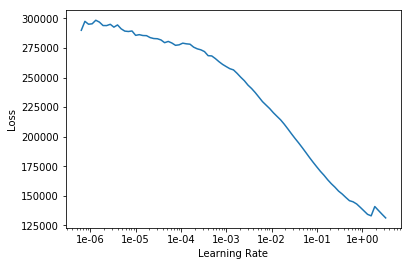

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
#with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

In [43]:
#recorder.add_exp(learn.recorder, "random init")
#viz(hooks)

# Results

In [44]:
recorder.plot_results_plotly(NB_EPOCHS, True)

In [45]:
x = range(len(activations_prestats[0]))


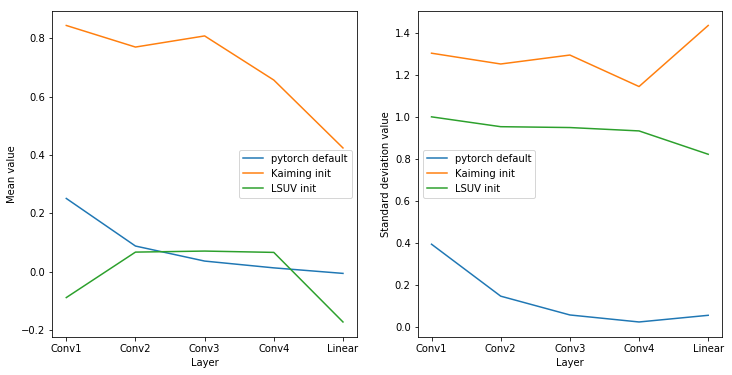

In [46]:
mean_prestat = []
std_prestat = []
for exp in activations_prestats:
    exp = np.array(exp)
    mean_prestat.append(exp[:, 0])
    std_prestat.append(exp[:, 1])


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.set_xlabel('Layer')
ax1.set_ylabel('Mean value')

ax2.set_xlabel('Layer')
ax2.set_ylabel('Standard deviation value')
for i, m in enumerate(mean_prestat):
    ax1.plot(x, m, label=recorder.labels[i])
for i, s in enumerate(std_prestat):
    ax2.plot(x, s, label=recorder.labels[i])
    
ax1.xaxis.set_ticks(x)
ax2.xaxis.set_ticks(x)
ax1.xaxis.set_ticklabels(('Conv1', 'Conv2', 'Conv3', 'Conv4', 'Linear'))
ax2.xaxis.set_ticklabels(('Conv1', 'Conv2', 'Conv3', 'Conv4', 'Linear'))
   
ax1.legend()    
ax2.legend()